In [ ]:
#imports (reminder to come back and clean this up)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import scipy.io
import numpy as np
import glob
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import os
from PIL import Image
import gc
from tensorflow.keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
test_data = pd.read_csv('/content/test_final.csv')
train_data = pd.read_csv('/content/train_final.csv')

In [ ]:
print(train_data.head())
print(test_data.head())

       image         x1         y1          x2          y2  \
0  00001.jpg  14.560000  64.960000  212.426667  210.000000   
1  00002.jpg   8.960000  38.494815  216.035556  194.797037   
2  00003.jpg  29.750000  50.866667  210.350000  177.800000   
3  00004.jpg  66.240000  63.515152  158.293333  177.131313   
4  00005.jpg  21.777778  74.666667  206.888889  205.333333   

                                  Car Name  class_id  
0                  ['Audi TTS Coupe 2012']        14  
1                  ['Acura TL Sedan 2012']         3  
2           ['Dodge Dakota Club Cab 2007']        91  
3     ['Hyundai Sonata Hybrid Sedan 2012']       134  
4  ['Ford F-450 Super Duty Crew Cab 2012']       106  
       image         x1         y1          x2          y2  \
0  00001.jpg  24.347826  64.000000  199.652174  180.923077   
1  00002.jpg  35.000000  11.822222  201.600000  126.311111   
2  00003.jpg  11.156250  31.740891  211.750000  199.211876   
3  00004.jpg  23.450000  39.200000  203.350000  1

In [ ]:
train_data.drop(train_data.columns.difference(['image', 'Car Name']), axis=1, inplace=True)
test_data.drop(test_data.columns.difference(['image', 'Car Name']), axis=1, inplace=True)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/drive/MyDrive/cars_train/cars_train_resized',
    x_col='image',
    y_col='Car Name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)



Found 8166 validated image filenames belonging to 196 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/drive/MyDrive/cars_test/cars_test_resized',
    x_col='image',
    y_col='Car Name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 8057 validated image filenames belonging to 196 classes.


In [ ]:
gc.collect()

0

In [ ]:
#MobileNetV2 cell
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ActivityRegularization
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Flatten()(x)  # Flatten features from convolutional layers
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add a dense layer with L2 regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(196, activation='softmax')(x)  # Output layer for 196 classes

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#resnet cell
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import ActivityRegularization
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Flatten()(x)  # Flatten features from convolutional layers
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)  # Add a dense layer with L2 regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.02))(x)  # Add a dense layer with L1 regularization
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(196, activation='softmax')(x)  # Output layer for 196 classes

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Compile the model for training
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use Adam optimizer with learning rate 0.0001
    loss='categorical_crossentropy',  # Categorical crossentropy loss for multi-class classification
    metrics=['accuracy']  # Monitor accuracy during training
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on your dataset
history = model.fit(
    train_generator,  # Provide training data in batches
    epochs=100,  # Train for 15 epochs
    validation_data=test_generator, callbacks=[early_stopping]  # Use a separate validation dataset
)





Epoch 1/100
256/256 [==============================] - 197s 602ms/step - loss: 253.9398 - accuracy: 0.0116 - val_loss: 157.1386 - val_accuracy: 0.0051
Epoch 2/100
256/256 [==============================] - 148s 579ms/step - loss: 91.3642 - accuracy: 0.0642 - val_loss: 41.5660 - val_accuracy: 0.0088
Epoch 3/100
256/256 [==============================] - 147s 576ms/step - loss: 20.8066 - accuracy: 0.0617 - val_loss: 11.7503 - val_accuracy: 0.0170
Epoch 4/100
256/256 [==============================] - 152s 595ms/step - loss: 9.7982 - accuracy: 0.0115 - val_loss: 8.2831 - val_accuracy: 0.0081
Epoch 5/100
256/256 [==============================] - 149s 580ms/step - loss: 7.3810 - accuracy: 0.0091 - val_loss: 6.6857 - val_accuracy: 0.0087
Epoch 6/100
256/256 [==============================] - 152s 594ms/step - loss: 6.2844 - accuracy: 0.0102 - val_loss: 5.9792 - val_accuracy: 0.0133
Epoch 7/100
256/256 [==============================] - 149s 582ms/step - loss: 5.8072 - accuracy: 0.0067 - val

KeyboardInterrupt: 

In [ ]:
import PIL
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

# Load the image
img_path = '/content/drive/MyDrive/cars_test/cars_test_resized/01006.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Decode predictions (optional, if you have class labels)
decoded_predictions = np.argmax(predictions, axis=1)

# Print the predictions or use them as needed
print(decoded_predictions)

1/1 [==============================] - 0s 27ms/step
[128]


Predicted class: ['Honda Accord Sedan 2012']


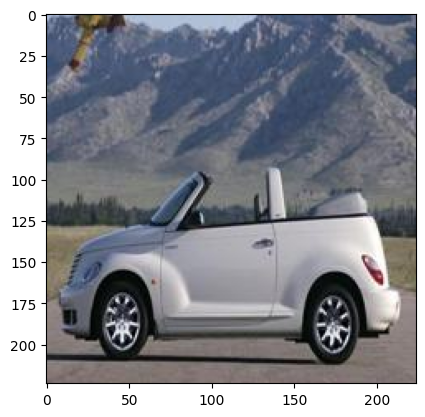

In [ ]:
# prompt: read this file /content/class_names.csv and show image /content/drive/MyDrive/cars_test/cars_test_resized/01000.jpg

import pandas as pd
import PIL
import matplotlib.pyplot as plt
# Read the class names from the CSV file
class_names = pd.read_csv('/content/class_names.csv')

# Load the image
img_path = '/content/drive/MyDrive/cars_test/cars_test_resized/01006.jpg'
img = PIL.Image.open(img_path)

# Display the image
img.show()

# Get the predicted class index
predicted_class_index = decoded_predictions[0]

# Get the class name from the class names DataFrame
predicted_class_name = class_names.iloc[predicted_class_index]['class_description']

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")
#show the image
plt.imshow(img)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model


# Save the model in the SavedModel format
model.save('mobilenetv2_saved_model')